<a href="https://colab.research.google.com/github/LeyloJohnny/First-ML/blob/main/collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 11.2MB/s 
     |████████████████████████████████| 194kB 22.5MB/s 
     |████████████████████████████████| 1.2MB 23.3MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 12.8MB 217kB/s 
     |████████████████████████████████| 776.8MB 25kB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

# A First Look at the Data

In [4]:
#get dataset of movies
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


For instance, assuming these factors range between -1 and +1, with positive numbers indicating stronger matches and negative numbers weaker ones, and the categories are science-fiction, action, and old movies, then we could represent the movie The Last Skywalker as:

In [6]:
last_skywalker = np.array([0.98,0.9,-0.9])

Here, for instance, we are scoring very science-fiction as 0.98, very action as 0.9, and very not old as -0.9. We could represent a user who likes modern sci-fi action movies as:

In [7]:
user1 = np.array([0.9,0.8,-0.6])

The match between this combination can be calculated via dot product.

**dot product**: The mathematical operation of multiplying the elements of two vectors together, and then summing up the result.

In [8]:
#dot product!
(user1*last_skywalker).sum()

2.1420000000000003

Example for another movie (Casablanca):

In [9]:
casablanca = np.array([-0.99,-0.3,0.8])
(user1*casablanca).sum()

-1.611

Problem: We don't know what the latent factors are. So we should learn them!


## Learning the Latent Factors

Step 1: Initialize random parameters 

Step 2: Make predictions (using dot product)

Step 3: Calculate the loss (using mean squared error)

Optimize our parameters (that is, the latent factors) using stochastic gradient descent (to minimize the loss). 

At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. 

After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.

## Creating the DataLoaders

In [11]:
#show movie titles indtead of IDs
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [12]:
#merge with ratings
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [13]:
#create dataloaders object
#dataloaders would take the first 3 columns by default --> but we want the title to be the second column (specified by item_name = title)
dls = CollabDataLoaders.from_df(ratings,item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


To represent collaborative filtering in PyTorch we can't just use the crosstab representation directly, especially if we want it to fit into our deep learning framework. We can represent our movie and user latent factor tables as simple matrices:

In [14]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [15]:
#get number of users, movies, and factors (amount of latent factors)
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

#initialize random latent factors
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

To calculate the result for a particular movie and user combination, we have to look up the index of the movie in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors. But look up in an index is not an operation our deep learning models know how to do. They know how to do matrix products, and activation functions.

Fortunately, it turns out that we can represent look up in an index as a matrix product. The trick is to replace our indices with one-hot-encoded vectors. Here is an example of what happens if we multiply a vector by a one-hot-encoded vector representing the index 3:


In [16]:
one_hot_3 = one_hot(3, n_users).float()

In [17]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

It gives us the same vector as the one at index 3 in the matrix:

In [18]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

But: we don't need this vector. 

Therefore, most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an embedding.

Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the embedding matrix.

## Collaborative Filtering from Scratch

Example on how to define a class: 

In [19]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

The most important piece of this is the special method called __init__(pronounced dunder init). In Python, any method surrounded in double underscores like this is considered special. It indicates that there is some extra behavior associated with this method name. In the case of __init__, this is the method Python will call when your new object is created. So, this is where you can set up any state that needs to be initialized upon object creation. Any parameters included when the user constructs an instance of your class will be passed to the __init__ method as parameters. Note that the first parameter to any method defined inside a class is self, so you can use this to set and get any attributes that you will need:

In [20]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

PyTorch already provides a Module class, which provides some basic foundations that we want to build on. So, we add the name of this superclass after the name of the class that we are defining, as shown in the following example.

The final thing that you need to know to create a new PyTorch module is that when your module is called, PyTorch will call a method in your class called forward, and will pass along to that any parameters that are included in the call. Here is the class defining our dot product model:

In [21]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

Note that the input of the model is a tensor of shape batch_size x 2, where the first column (x[:, 0]) contains the user IDs and the second column (x[:, 1]) contains the movie IDs. As explained before, we use the embedding layers to represent our matrices of user and movie latent factors:

In [22]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

Create a Learner:

In [23]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

Fit the model:

In [24]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:10
1,1.093331,1.109981,00:10
2,0.958258,0.990199,00:10
3,0.814234,0.894916,00:10
4,0.780714,0.882022,00:10


The first thing we can do to make this model a little bit better is to force those predictions to be between 0 and 5. For this, we just need to use sigmoid_range. One thing we discovered empirically is that it's better to have the range go a little bit over 5, so we use (0, 5.5):

In [25]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

Fit again using new model:

In [26]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:11
1,0.878134,0.918898,00:11
2,0.675850,0.875467,00:10
3,0.483372,0.877939,00:10
4,0.378927,0.881887,00:10


This is a reasonable start, but we can do better. One obvious missing piece is that some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others. But in our dot product representation we do not have any way to encode either of these things. If all you can say about a movie is, for instance, that it is very sci-fi, very action-oriented, and very not old, then you don't really have any way to say whether most people like it.

That's because at this point we only have weights; we do not have biases. If we have a single number for each user that we can add to our scores, and ditto for each movie, that will handle this missing piece very nicely. So first of all, let's adjust our model architecture:

In [27]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

Let's try that:

In [28]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:12
1,0.846664,0.865633,00:12
2,0.608090,0.865127,00:12
3,0.413482,0.887318,00:12
4,0.286971,0.894876,00:12


Oh no, it's getting worse!
This is a clear indication of overfitting. In this case, there is no way to use data augmentation, so we will have to use another regularization technique. One approach that can be helpful is weight decay.

### Weight Decay

Weight decay, or L2 regularization, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function. If we take the basic example of a parabola, y = a * (x**2), the larger a is, the more narrow the parabola is

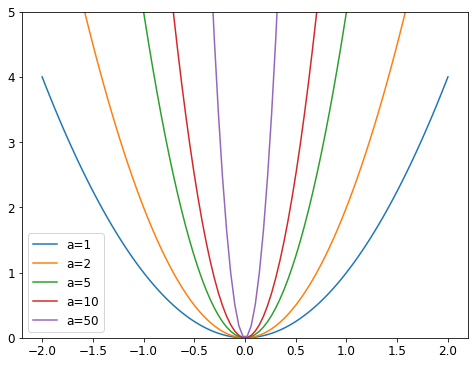

In [32]:
#hide_input
#id parabolas
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

To use weight decay in fastai, just pass wd in your call to fit or fit_one_cycle:

In [31]:
#add weight decay to prevent overfitting
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:11
1,0.888625,0.882614,00:11
2,0.771066,0.832743,00:11
3,0.599807,0.822374,00:11
4,0.504981,0.822528,00:11


Build class without Embedding:

In [36]:
#random parameter initialization
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [37]:
#build class
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [38]:
#train model
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.923278,0.947485,00:12
1,0.867184,0.878225,00:12
2,0.722469,0.835867,00:12
3,0.589465,0.824819,00:12
4,0.477854,0.824497,00:12


In [39]:
#the five worst movies
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Robocop 3 (1993)',
 "Joe's Apartment (1996)"]

In [40]:
#best movies?
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

Look at movies after PCA?

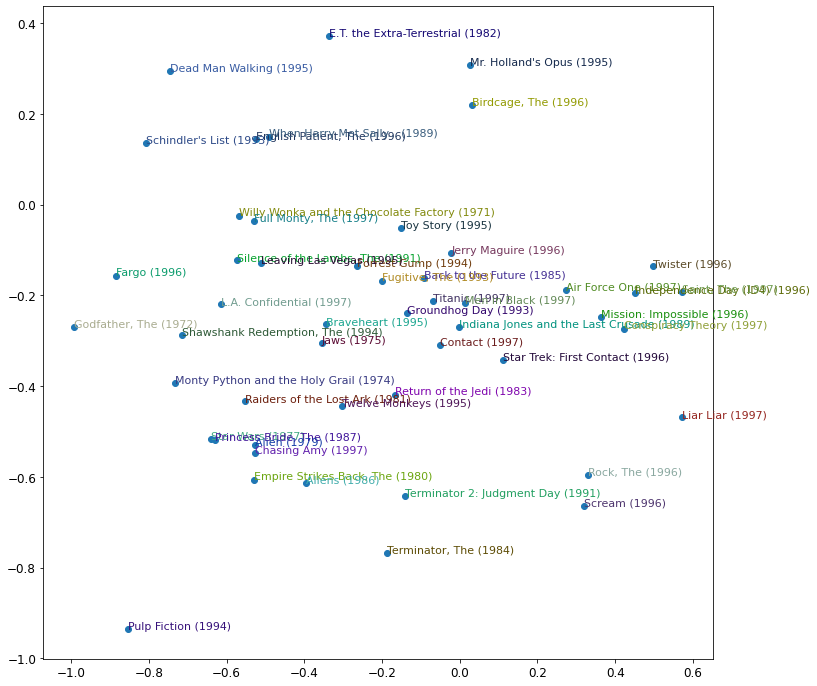

In [41]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

After building the model from scratch, we can just use fastai...

## Using fastai.collab

We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's collab_learner:

In [42]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [43]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.939655,0.957980,00:12
1,0.841034,0.876615,00:11
2,0.722659,0.835347,00:12
3,0.600329,0.821595,00:11
4,0.477595,0.822365,00:12


In [44]:
#print the model to see the names of the layers
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

We can use these to replicate any of the analyses we did in the previous section—for instance:

In [45]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

Another interesting thing we can do with these learned embeddings is to look at distance.

## Embedding Distance

Make recommendation based on embedding distance:

In [46]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Wedding Gift, The (1994)'

## Deep Learning for Collaborative Filtering

To turn our architecture into a deep learning model, the first step is to take the results of the embedding lookup and concatenate those activations together. This gives us a matrix which we can then pass through linear layers and nonlinearities in the usual way.

Since we'll be concatenating the embeddings, rather than taking their dot product, the two embedding matrices can have different sizes (i.e., different numbers of latent factors). fastai has a function get_emb_sz that returns recommended sizes for embedding matrices for your data, based on a heuristic that fast.ai has found tends to work well in practice:


In [47]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

Let's implement this class:

In [48]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

And use it to create a model:

In [49]:
model = CollabNN(*embs)

CollabNN creates our Embedding layers in the same way as previous classes in this chapter, except that we now use the embs sizes. self.layers is identical to the mini-neural net we created in <> for MNIST. Then, in forward, we apply the embeddings, concatenate the results, and pass this through the mini-neural net. Finally, we apply sigmoid_range as we have in previous models.

Let's see if it trains:


In [50]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.942991,0.949061,00:13
1,0.913394,0.897858,00:12
2,0.847262,0.880603,00:12
3,0.809485,0.873346,00:13
4,0.755841,0.875979,00:12


fastai provides this model in fastai.collab if you pass use_nn=True in your call to collab_learner (including calling get_emb_sz for you), and it lets you easily create more layers. For instance, here we're creating two hidden layers, of size 100 and 50, respectively:

In [51]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.998229,1.025625,00:15
1,0.878424,0.932472,00:15
2,0.881409,0.893211,00:15
3,0.809828,0.868056,00:15
4,0.792271,0.865563,00:15


learn.model is an object of type EmbeddingNN. Let's take a look at fastai's code for this class:

In [ ]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

Wow, that's not a lot of code! This class inherits from TabularModel, which is where it gets all its functionality from. In __init__ it calls the same method in TabularModel, passing n_cont=0 and out_sz=1; other than that, it only passes along whatever arguments it received.